In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import drive
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/dataset_hackaton_2024.zip -d /content/data/

Archive:  /content/drive/MyDrive/dataset_hackaton_2024.zip
   creating: /content/data/dataset_hackaton_2024/test/
   creating: /content/data/dataset_hackaton_2024/test/inappropriate/
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/_Aj2vHGWN4A.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/6m-Cbw1J9G4.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/CkhREf7earc.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/d92ylc627TI.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/FHQjn72ziBo.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/HFA65Z2-k_I.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/i91-4Ax8KuA.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/kypeY1St5ec.jpg  
  inflating: /content/data/dataset_hackaton_2024/test/inappropriate/mAYDf_EpUao.jpg  
  inflating: /content/data/dataset_hackaton

## Defining contstants

In [34]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
CLASS_NAMES = {
    'safe': 0,
    'inappropriate': 1
}

DATA_ROOT = '/content/data/dataset_hackaton_2024'

## Define the model

In [5]:
vgg19 = torchvision.models.vgg19(torchvision.models.VGG19_Weights.IMAGENET1K_V1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 108MB/s] 


In [117]:
# redefine the classifier
classifier = nn.Sequential(nn.Linear(25088, 4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 1000, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(1000, 1, bias=True))

In [139]:
class Model(nn.Module):
    def __init__(self, classifier:nn.Module, freeze: bool):
        super().__init__()
        self.extractor = vgg19.features
        for param in self.extractor.parameters():
            param.requires_grad = not freeze
        self.flatten = nn.Flatten(1, 3)
        self.classifier = classifier
    def forward(self, x):
        features = self.extractor(x)
        # print(features.mean())
        flattened = self.flatten(features)
        classes = self.classifier(flattened)
        # print(classes.mean())
        return torch.nn.functional.sigmoid(classes)


model = Model(classifier, True)

#### Augments and utility functoins

In [140]:
preprocessors = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) # inference time

augments = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.2)),
    transforms.RandomRotation(15),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) #train time


In [38]:
def show_image(img):
  if isinstance(img, torch.Tensor):
      plt.imshow(img.view(-1, IMAGE_SIZE, IMAGE_SIZE).permute(1,
                  2, 0).detach().cpu().numpy())
  elif isinstance(img, str):
      img = Image.open(img)
      plt.imshow(img)
  else:
      plt.imshow(img)
  plt.show()

In [10]:
# img_tensor = preprocessors(Image.open('../image.png'))
# show_image(img_tensor)
# model(img_tensor) # try to infer the model

#### Define dataset

In [141]:
class ImageDataset(Dataset):
    def __init__(self, root, transform, mode) -> None:
        self.mode = mode
        self.transforms = transform
        self.files = list()
        self.labels = list()
        image_set_name = 'train'
        if self.mode == 'test':
            image_set_name = 'test'
        if self.mode == 'valid':
            image_set_name = 'valid'

        dir = os.path.join(root, image_set_name)
        for class_dir in os.listdir(dir):
            path_to_all_calss_files = os.path.join(dir, class_dir)
            for filename in os.listdir(path_to_all_calss_files):
                full_path = os.path.join(path_to_all_calss_files, filename)
                if os.path.isfile(full_path):
                    self.files.append(full_path)
                    self.labels.append(CLASS_NAMES[class_dir.lower()])

        assert len(self.labels) == len(
            self.files), "each file should have a label"

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img = self.transforms(img)
        labels = self.labels[index % len(self.labels)]

        return (img, torch.tensor(labels, dtype=torch.float32))

    def __len__(self):
        return len(self.files)

In [142]:
train_dataset = ImageDataset(DATA_ROOT, augments, 'train')
valid_dataset = ImageDataset(DATA_ROOT, preprocessors, 'valid')
test_dataset = ImageDataset(DATA_ROOT, preprocessors, 'test')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [84]:
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

In [143]:
def train(model, epochs, loss_function, lr = 0.01):
    template = '[{:3}/{:3}]\ttrain loss: {:2.3f}\tval loss: {:2.3f}'
    history = {'train':list(), 'val':list()}
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_train, epoch_val = 0, 0
        for batch in train_dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = loss_function(preds.view(-1), labels)
            loss.backward()
            optimizer.step()

            epoch_train+=loss
        epoch_train /= len(train_dataloader)
        history['train'].append(epoch_train.item())

        model.eval()
        for batch in valid_dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                preds = model(images)
                # show_image(images[0])
                loss = loss_function(preds.view(-1), labels)

            epoch_val+=loss
        epoch_val /= len(valid_dataloader)
        history['val'].append(epoch_val.item())
        print(template.format(epoch+1, epochs, epoch_train, epoch_val))
    return history

In [145]:
history_mse = train(model, 10, mse_loss, lr=0.05) # seeing some problems...

  0%|          | 0/10 [00:00<?, ?it/s]

[  1/ 10]	train loss: 0.502	val loss: 0.500
[  2/ 10]	train loss: 0.465	val loss: 0.500
[  3/ 10]	train loss: 0.507	val loss: 0.500
[  4/ 10]	train loss: 0.522	val loss: 0.500
[  5/ 10]	train loss: 0.502	val loss: 0.500
[  6/ 10]	train loss: 0.492	val loss: 0.500
[  7/ 10]	train loss: 0.485	val loss: 0.500
[  8/ 10]	train loss: 0.475	val loss: 0.500
[  9/ 10]	train loss: 0.480	val loss: 0.500
[ 10/ 10]	train loss: 0.450	val loss: 0.500


In [45]:
def plot_history(history):
    epochs = len(history['train'])
    plt.plot(range(epochs), history['train'], label = 'train')
    plt.plot(range(epochs), history['val'], label = 'val')
    plt.legend()

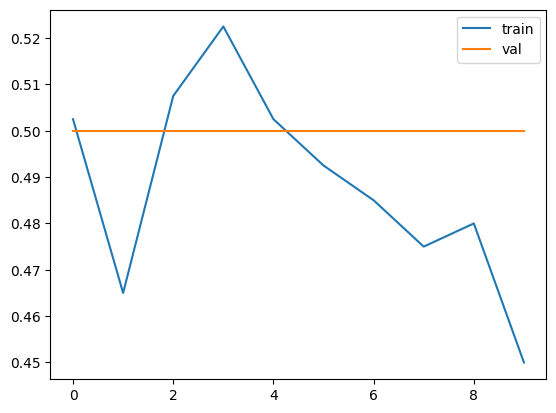

In [146]:
plot_history(history_mse)